In [12]:
import pandas_datareader as pdr

In [194]:
import pandas as pd
import requests
from datetime import datetime, timedelta

# Define the API key and endpoint
key = "584af904caa8256485f003a94c0f5417e82c018d"
endpoint = "https://api.tiingo.com/tiingo/daily/MSFT/prices"

end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

# Format dates as strings
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')
# Define parameters and headers
params = {
    'token': key,
    'startDate': start_date_str,
    'endDate': end_date_str
}
headers = {
    'Content-Type': 'application/json'
}

# Make the request
response = requests.get(endpoint, headers=headers, params=params)

# Check for a successful response
if response.status_code == 200:
    # Parse the JSON data
    data = response.json()
    # Convert to DataFrame
    df = pd.DataFrame(data)
    print(df.head())
else:
    print(f"Error: {response.status_code}")

# Output the DataFrame
df.head()


                       date   close    high     low    open    volume  \
0  2019-06-14T00:00:00.000Z  132.45  133.79  131.64  132.26  17821703   
1  2019-06-17T00:00:00.000Z  132.85  133.73  132.53  132.63  14517785   
2  2019-06-18T00:00:00.000Z  135.16  135.24  133.57  134.19  25934458   
3  2019-06-19T00:00:00.000Z  135.69  135.93  133.81  135.00  23744441   
4  2019-06-20T00:00:00.000Z  136.95  137.66  135.72  137.45  33042592   

     adjClose     adjHigh      adjLow     adjOpen  adjVolume  divCash  \
0  126.294724  127.572451  125.522367  126.113554   17821703      0.0   
1  126.676135  127.515239  126.371006  126.466359   14517785      0.0   
2  128.878784  128.955066  127.362675  127.953862   25934458      0.0   
3  129.384153  129.613000  127.591521  128.726219   23744441      0.0   
4  130.585598  131.262602  129.412759  131.062362   33042592      0.0   

   splitFactor  
0          1.0  
1          1.0  
2          1.0  
3          1.0  
4          1.0  


,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2019-06-14T00:00:00.000Z,132.45,133.79,131.64,132.26,17821703,126.294724,127.572451,125.522367,126.113554,17821703,0.0,1.0
1,2019-06-17T00:00:00.000Z,132.85,133.73,132.53,132.63,14517785,126.676135,127.515239,126.371006,126.466359,14517785,0.0,1.0
2,2019-06-18T00:00:00.000Z,135.16,135.24,133.57,134.19,25934458,128.878784,128.955066,127.362675,127.953862,25934458,0.0,1.0
3,2019-06-19T00:00:00.000Z,135.69,135.93,133.81,135.00,23744441,129.384153,129.613000,127.591521,128.726219,23744441,0.0,1.0
4,2019-06-20T00:00:00.000Z,136.95,137.66,135.72,137.45,33042592,130.585598,131.262602,129.412759,131.062362,33042592,0.0,1.0


In [198]:
df = df.reset_index()['close']

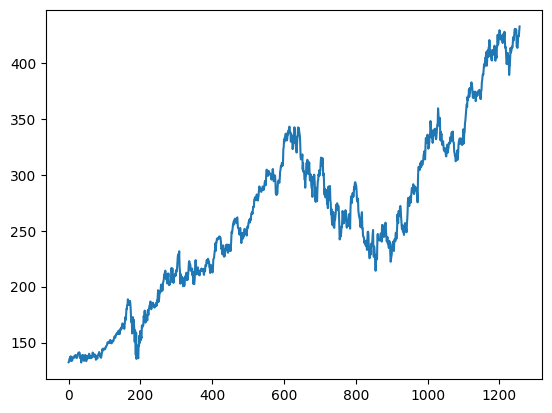

In [200]:
import matplotlib.pyplot as plt
plt.plot(df)

In [201]:
## Apply minmax scaler to the data since LSTM is sensitive to scale of the data

In [202]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [203]:
scaler = MinMaxScaler(feature_range = (0, 1))
df = scaler.fit_transform(np.array(df).reshape(-1, 1)) # 1 column and as many rows needed

In [204]:
# We can't just do train_test_split since this is not regression or classification and data at each point is dependent on 
# previous data and influences the future data
train_size = int(len(df)*0.65)
test_size = len(df) - train_size

In [205]:
print(train_size, test_size)

817 440


In [206]:
train_data = df[0:train_size,:]
test_data = df[train_size:len(df),:]

In [207]:
print(len(train_data), len(test_data))

817 440


In [208]:
""" now we need to select a window size for the input and output generation.
example data : a, b, c, d, e, f

X_train      y_train
a b c          d
b c d          e
c d e          f

we need to do this for test data as well
"""

' now we need to select a window size for the input and output generation.\nexample data : a, b, c, d, e, f\n\nX_train      y_train\na b c          d\nb c d          e\nc d e          f\n\nwe need to do this for test data as well\n'

In [209]:
import numpy as np

def create_dataset(data, time_stamp):
    dataX, datay = [], []
    for i in range(len(data) - time_stamp - 1):
        a = data[i : i + time_stamp, 0]
        b = data[i + time_stamp, 0]
        dataX.append(a)
        datay.append(b)
    return np.array(dataX), np.array(datay)
        

In [210]:
time_stamp = 100
X_train, y_train = create_dataset(train_data, time_stamp)
X_test, y_test = create_dataset(test_data, time_stamp)

In [211]:
print(X_train.shape, y_train.shape)

(716, 100) (716,)


In [212]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [213]:
# Stacked LSTM Model implementation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input

In [214]:
model = Sequential()
model.add(Input(shape = (100, 1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [215]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [216]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - loss: 0.0935 - val_loss: 0.0393
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 0.0090 - val_loss: 0.0061
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - loss: 0.0057 - val_loss: 0.0213
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - loss: 0.0025 - val_loss: 0.0060
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2

In [217]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


In [218]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [219]:
import math
from sklearn.metrics import mean_squared_error

train_rmse = math.sqrt(mean_squared_error(train_predict, y_train))
test_rmse = math.sqrt(mean_squared_error(test_predict, y_test))
print(train_rmse, test_rmse)

247.331964119406 349.7458063649404


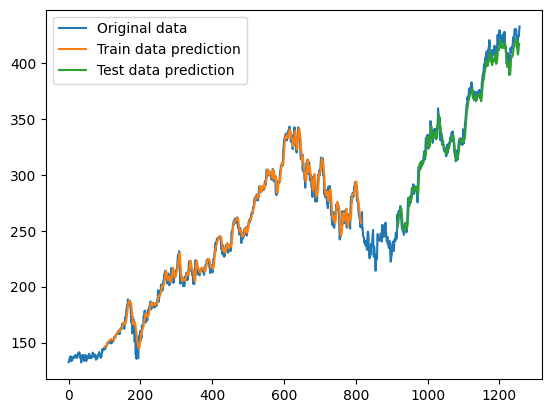

In [220]:
### Plotting 
look_back=100
trainPredictPlot = numpy.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df), label = 'Original data')
plt.plot(trainPredictPlot, label = 'Train data prediction')
plt.plot(testPredictPlot, label = 'Test data prediction')
plt.legend()

In [221]:
len(test_data)

440

In [222]:
x_input=test_data[340:].reshape(1,-1)
x_input.shape

(1, 100)

In [223]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [224]:
temp_input ## stock prices of last 100 days (scaled)

[0.8868106632941724,
 0.8796219256498152,
 0.887576130728525,
 0.8997570472925749,
 0.9074450028289012,
 0.904316570705894,
 0.9235863813359071,
 0.9198256065497386,
 0.8831830132791958,
 0.9038173528139246,
 0.9285785602555996,
 0.9100409358671413,
 0.9095084367823743,
 0.9379971378174192,
 0.938196824974207,
 0.9596299131360866,
 0.9420241621459711,
 0.912270775784604,
 0.9228209139015542,
 0.9130695244117548,
 0.9047492262122674,
 0.9005225147269278,
 0.8984923619662528,
 0.9300096515459111,
 0.9256498152893797,
 0.916331081305954,
 0.9161313941491662,
 0.916930142776317,
 0.9366326089127033,
 0.9428229107731219,
 0.940892601590841,
 0.9000565780277563,
 0.8981928312310712,
 0.9216560721536258,
 0.9119379638566245,
 0.906280161080973,
 0.9420907245315671,
 0.941491663061204,
 0.9751722301727292,
 0.9458847805105335,
 0.9488800878623489,
 0.9624920957167105,
 0.9752055113655274,
 0.9889839251838786,
 0.9868872100376076,
 0.9673178686724131,
 0.963290844343861,
 0.9625586581023062,
 0

In [225]:
# demonstrate prediction for next 30 days using the last 100 days data and the newly predicted data
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.95747197]
101
1 day input [0.87962193 0.88757613 0.89975705 0.907445   0.90431657 0.92358638
 0.91982561 0.88318301 0.90381735 0.92857856 0.91004094 0.90950844
 0.93799714 0.93819682 0.95962991 0.94202416 0.91227078 0.92282091
 0.91306952 0.90474923 0.90052251 0.89849236 0.93000965 0.92564982
 0.91633108 0.91613139 0.91693014 0.93663261 0.94282291 0.9408926
 0.90005658 0.89819283 0.92165607 0.91193796 0.90628016 0.94209072
 0.94149166 0.97517223 0.94588478 0.94888009 0.9624921  0.97520551
 0.98898393 0.98688721 0.96731787 0.96329084 0.96255866 0.96019569
 0.97300895 0.96259194 0.9592971  0.95074383 0.97617067 0.97307552
 0.97870004 0.96864912 0.98419143 0.96412287 0.93663261 0.93976104
 0.93064199 0.90544813 0.88830832 0.89443206 0.91643092 0.92138982
 0.88804207 0.91227078 0.89872533 0.85572603 0.87439678 0.88404832
 0.91340234 0.9362998  0.9223217  0.92631544 0.93223949 0.94029354
 0.93689886 0.94635072 0.96805005 0.96109429 0.95849835 0.9755716
 0.98788565 0.99281126 0.98109628 0

In [226]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [227]:
len(df)

1257

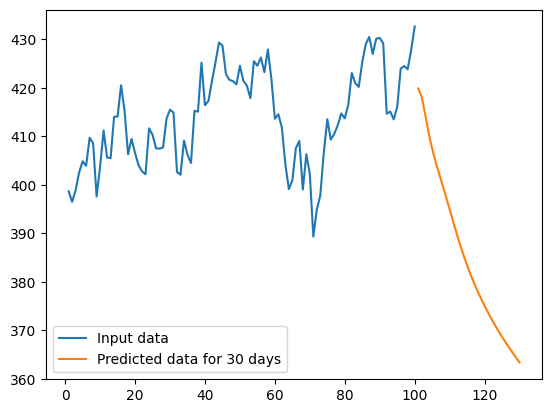

In [230]:
plt.plot(day_new,scaler.inverse_transform(df[1157:]), label = 'Input data')
plt.plot(day_pred,scaler.inverse_transform(lst_output), label = 'Predicted data for 30 days')
plt.legend()